In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
from config import CONFIG, RL_CONFIG, SWING_CONFIG
from environment.grid import Grid
from environment.swing.solver import swing_solver
from environment.trajectory import is_stable
from environment.node import NodeType

DTYPE = CONFIG.swing.dtype
# CONFIG.from_yaml("config.yaml")

In [2]:
def find_steady_state(
    grid: Grid, rng: np.random.Generator, initial_phase: npt.NDArray[DTYPE] | None = None, initial_dphase: npt.NDArray[DTYPE] | None = None
) -> tuple[npt.NDArray[DTYPE], npt.NDArray[DTYPE]]:
    """Find random initial state of given grid.
    Args
        grid: In which grid to find initial state
        rng: used for initializing random phase
    Return
        phase: [S, N] phase of each node in (-pi, pi]
        dphase: [S, N] dphase (angular frequency) of each node
    """

    # Initial random state
    # phase = rng.uniform(-np.pi, np.pi, grid.num_nodes).astype(np.float32)
    if initial_phase is None:
        phase = np.zeros(grid.num_nodes, dtype=DTYPE)
    else:
        phase = initial_phase
    if initial_dphase is None:
        dphase = np.zeros_like(phase, dtype=DTYPE)
    else:
        dphase = initial_dphase

    phases, dphases = [phase], [dphase]

    # Run swing equation until reaching steady time
    time = 0.0
    solver = swing_solver(grid.weighted_adjacency_matrix, grid.params)
    while time < RL_CONFIG.steady_time:
        time += SWING_CONFIG._dt
        phase, dphase = solver(phase=phase, dphase=dphase)
        phases.append(phase)
        dphases.append(dphase)
        if is_stable(dphase):
            break

    return np.stack(phases), np.stack(dphases)



Node 0 - Type: CONSUMER, max: 20, active: 11
Node 1 - Type: SINK, max: 19, active: 11
Node 2 - Type: RENEWABLE, max: 10, active: 6
Node 3 - Type: CONSUMER, max: 20, active: 11
Node 4 - Type: GENERATOR, max: 18, active: 9
Node 5 - Type: GENERATOR, max: 18, active: 10
Node 6 - Type: GENERATOR, max: 12, active: 6
Node 7 - Type: GENERATOR, max: 18, active: 10
Node 8 - Type: CONSUMER, max: 20, active: 11
Node 9 - Type: RENEWABLE, max: 7, active: 3
Couldn't find steady state, max_dphase=49.13991614018575


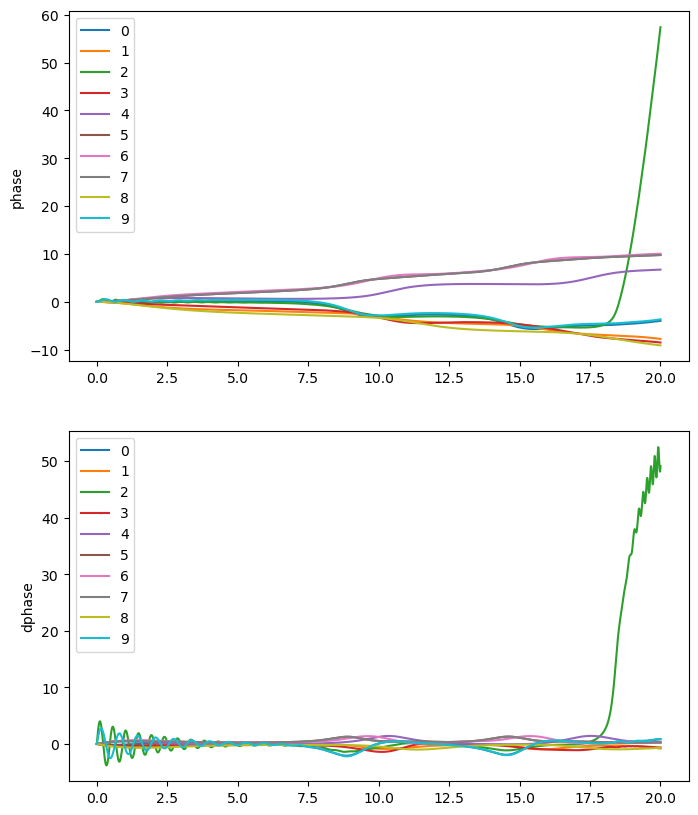

In [10]:
grid = Grid(rng=0)
# grid.reset_nodes()
# grid.reset_node_types()
# grid.reset_graph()
# grid.reset_coupling()

print(grid)

phases, dphases = find_steady_state(grid, grid.rng)
final_time = len(dphases) * SWING_CONFIG._dt
time = np.linspace(0.0, final_time, len(dphases))
max_dphase = np.abs(dphases[-1]).max()

if final_time >= RL_CONFIG.steady_time:
    print(f"Couldn'final_time find steady state, {max_dphase=}")
    steady_phase, steady_dphase = None, None
else:
    print(f"Steady at {final_time=}, {max_dphase=}")
    steady_phase, steady_dphase = phases[-1], dphases[-1]

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(8, 10))

for i, (phase, dphase) in enumerate(zip(phases.T, dphases.T)):
    ax1.plot(time[: len(phase)], phase, label=i)
    ax2.plot(time[: len(dphase)], dphase, label=i)

ax1.legend()
ax1.set_ylabel("phase")
ax2.legend()
ax2.set_ylabel("dphase")
# plt.xlim(0, time[-1])
# plt.show()
fig.show()

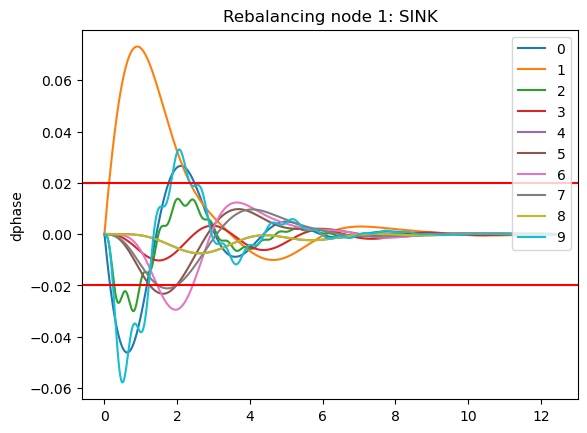

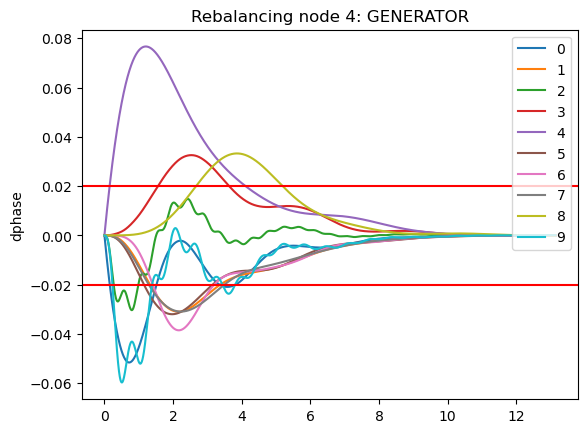

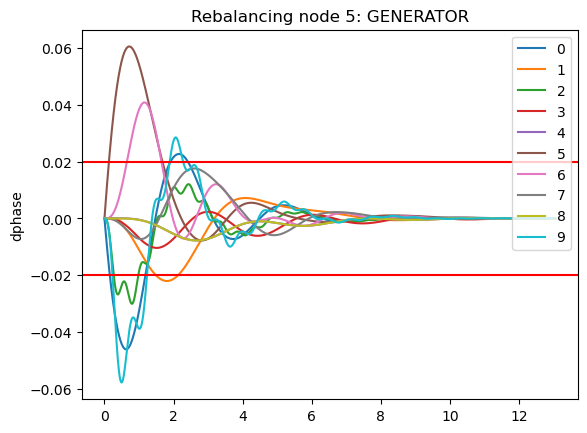

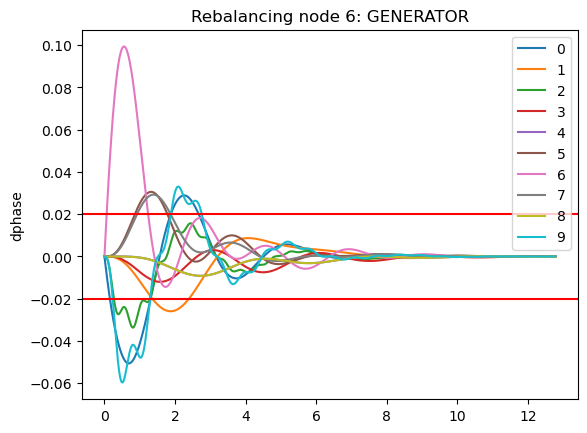

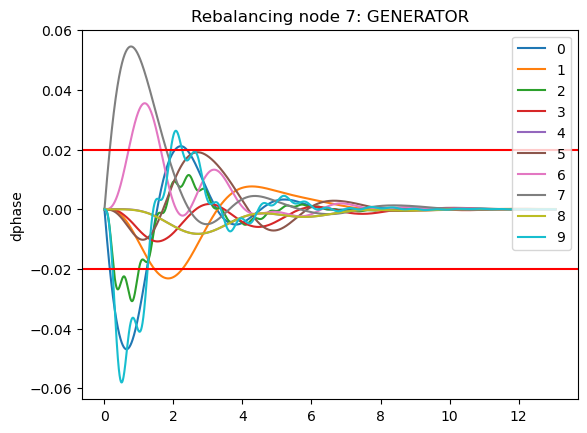

In [6]:
for i in range(grid.num_nodes):
    grid = Grid(rng=0)

    # Perturbation & rebalancing
    grid.nodes[0].increase()  # Consumer
    if grid.node_types[i] in [NodeType.CONSUMER, NodeType.RENEWABLE]:
        continue
    elif grid.node_types[i] is NodeType.SINK:
        grid.nodes[i].decrease()
    else:
        grid.nodes[i].increase()
    assert grid.power_imbalance == 0

    phases, dphases = find_steady_state(grid, grid.rng, steady_phase, steady_dphase)
    time = np.arange(0.0, RL_CONFIG.steady_time, SWING_CONFIG._dt)

    fig, ax = plt.subplots()
    for j, dphase in enumerate(dphases.T):
        ax.plot(time[: len(dphase)], dphase, label=j)
    ax.legend(loc="upper right")
    ax.set_ylabel("dphase")
    ax.axhline(0.02, color="r")
    ax.axhline(-0.02, color="r")
    ax.set_title(f"Rebalancing node {i}: {grid.node_types[i].name}")

    fig.show()

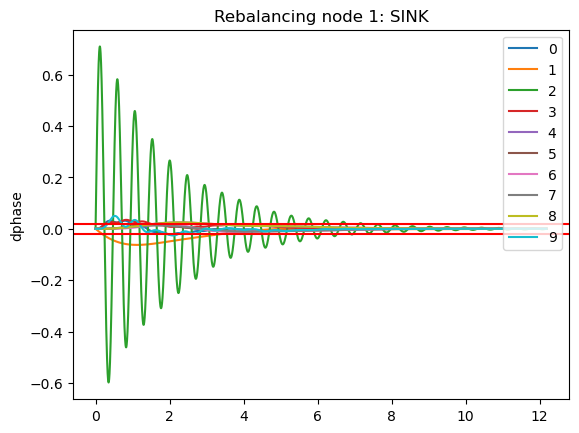

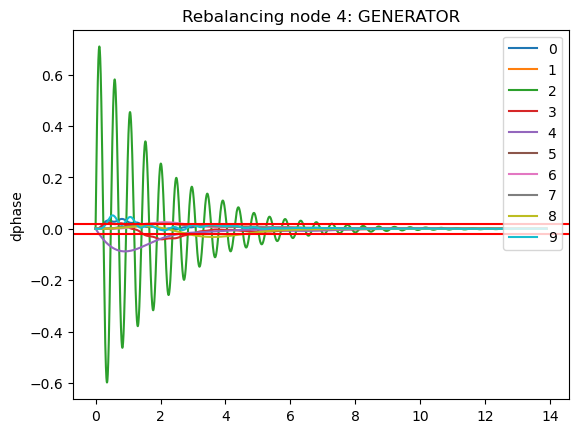

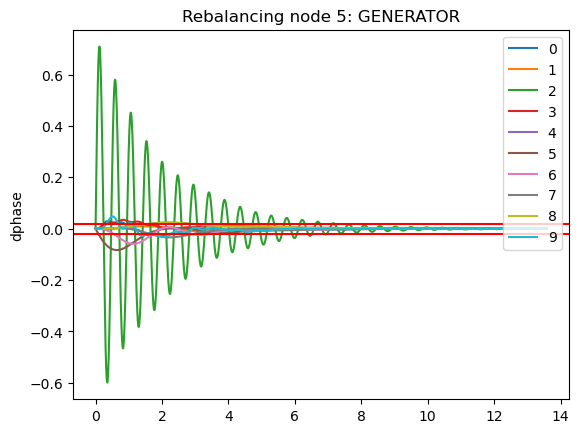

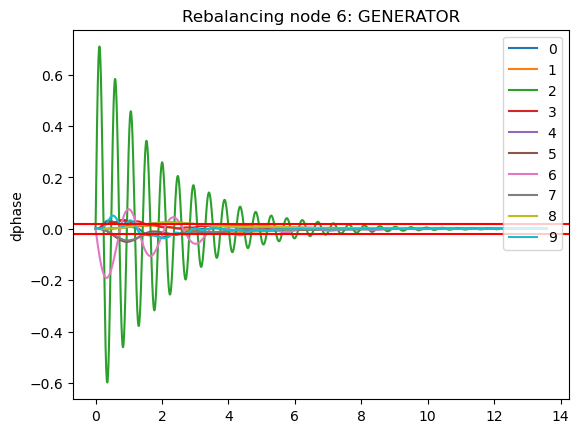

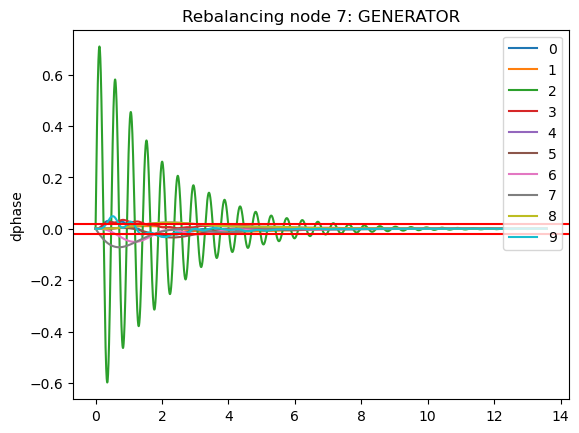

In [7]:
for i in range(grid.num_nodes):
    grid = Grid(rng=0)

    # Perturbation & rebalancing
    grid.nodes[2].increase()  # renewable
    if grid.node_types[i] in [NodeType.CONSUMER, NodeType.RENEWABLE]:
        continue
    elif grid.node_types[i] is NodeType.SINK:
        grid.nodes[i].increase()
    else:
        grid.nodes[i].decrease()
    assert grid.power_imbalance == 0

    phases, dphases = find_steady_state(grid, grid.rng, steady_phase, steady_dphase)
    time = np.arange(0.0, RL_CONFIG.steady_time, SWING_CONFIG._dt)

    fig, ax = plt.subplots()
    for j, dphase in enumerate(dphases.T):
        ax.plot(time[: len(dphase)], dphase, label=j)
    ax.legend(loc="upper right")
    ax.set_ylabel("dphase")
    ax.axhline(0.02, color="r")
    ax.axhline(-0.02, color="r")
    ax.set_title(f"Rebalancing node {i}: {grid.node_types[i].name}")

    fig.show()